In [1]:
regenerate = False

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib import pyplot as plt
import numpy as np

import camb
from camb import model, initialpower
import pandas as pd

In [3]:
import importlib.util
import sys
spec = importlib.util.spec_from_file_location(
    "spectra", "../shared/spectra.py")
spectra = importlib.util.module_from_spec(spec)
sys.modules["spectra"] = spectra
spec.loader.exec_module(spectra)

In [4]:
# Please refer to the notebook "what_is_truth"
# for a detailed review of this parameter.
asymptote_sample_size = 10

omega_index = 3 # while we debug, we confine our attention to just one value
onh2 = spectra.omegas_nu[omega_index]
onh2_str = spectra.omnu_strings[omega_index]
snap_index=0

In [5]:
model0 = {'OmM': 0.318584094,
 'OmL': 0.681415906,
 'OmK': 0.0,
 'OmC': 0.268584094,
 'OmB': 0.05,
 'h': 0.67,
 'w0': -1,
 'wa': 0,
 'omch2': 0.120567,
 'ombh2': 0.022445,
 'n_s': 0.96,
 'A_s': 2.12723788013000E-09,
}

In [6]:
'''
First, we need to define a Pandas table containing my exotic cosmologies.
'''
num_degenerate = 100 # how many models are we testing
cosm = None

if regenerate == True:
    def row_conglomerator():
        rows = [spectra.get_As_matched_cosmology() for i in range(num_degenerate)]
        rows.insert(0, model0)
        conglomerate = {}
        for key in rows[0].keys():
            conglomerate[key] = [rows[0][key]]
            for i in range(1, num_degenerate + 1):
                conglomerate[key].append(rows[i][key])
        return conglomerate

    conglomerate = row_conglomerator()
    cosm = pd.DataFrame.from_dict(conglomerate)
    # We need to write this dataframe as a CSV. Trying to retrieve it from
    # numpy seems obscure.
    cosm.to_csv("degenerate_cosmologies.csv")
else:
    cosm = pd.read_csv("degenerate_cosmologies.csv")

In [7]:
m0_only = pd.Series(model0).to_frame().T
m0_only

,OmM,OmL,OmK,OmC,OmB,h,w0,wa,omch2,ombh2,n_s,A_s
0,0.318584,0.681416,0.0,0.268584,0.05,0.67,-1.0,0.0,0.120567,0.022445,0.96,2.127238e-09


In [8]:
# It's a waste of time to consider all of the omegas and snapshots, so we're
# making heavy use of skips.
spec_sim = spectra.better_battery(spectra.omegas_nu, spectra.omnu_strings,
    skips_omega = [0, 1, 2], skips_model=[], skips_snapshot=[1, 2, 3],
    models=m0_only)

0123

In [9]:
target, redshifts = None, None

if regenerate:
    # The target should always be selected at snapshot
    # 0, i.e. z=2
    target = spec_sim[onh2_str][0][0]['s12_massless'][0]

    # We'll evaluate each cosmology at the corresponding
    # redshift entry here, to keep things even.
    redshifts = [2] # this is the redshift which in model 0 is associated with the
    # sigma12 value we're using
    for i in range(1, num_degenerate + 1):
        print(i  % 10, end='')
        z = spectra.match_s12(target, 0.001, cosm.loc[i])
        redshifts.append(z)

    np.save("degenerate_redshifts.npy", redshifts, allow_pickle=True)
else:
    redshifts = np.load("degenerate_redshifts.npy", allow_pickle=True)

1234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890

In [10]:
# This is a disgusting hack, but it's quite succinct
def decoy_parser(mindex):
    return [redshifts[mindex]]

spectra.parse_redshifts = decoy_parser

spec_sims = None
if regenerate:
    spec_sims = spectra.better_battery(spectra.omegas_nu, spectra.omnu_strings,
        skips_omega = [0, 1, 2], skips_model=[], skips_snapshot=[],
        models=cosm)

    np.save("degenerate_spectra.npy", spec_sims, allow_pickle=True)
else:
    spec_sims = np.load("degenerate_spectra.npy", allow_pickle=True)

0123

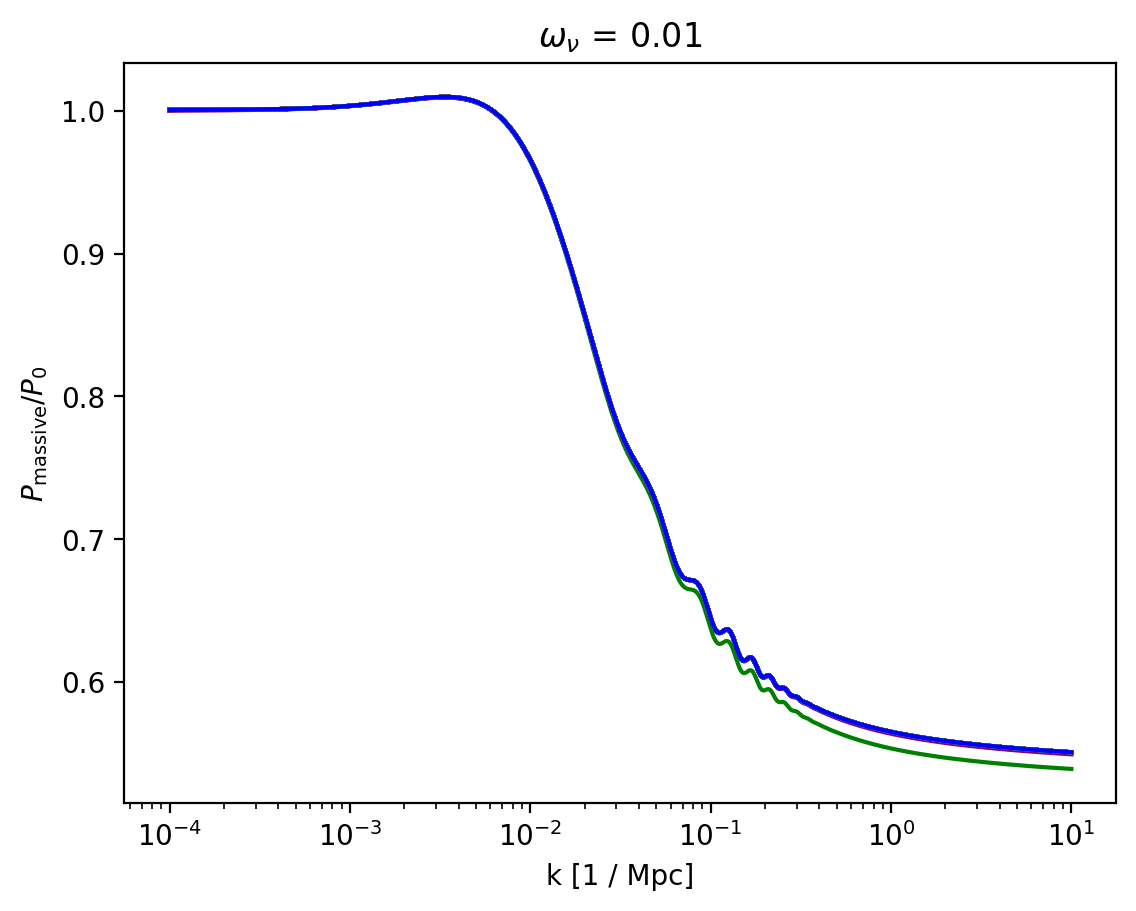

In [11]:
colors = spectra.colors * 200
styles = spectra.styles * 200
for i in range(len(spec_sims[onh2_str])):
    if spec_sims[onh2_str][i] is None:
        continue
    h = cosm.loc[i]["h"]
    for j in range(len(spec_sims[onh2_str][i])):
        sim = spec_sims[onh2_str][i][j]
        
        if sim is None:
            continue
        plt.plot(sim["k"],
            sim["P_nu"] / sim["P_no"],
            label="model " + str(i) + ", z=" + str(sim["z"]), c=colors[i],
            linestyle=styles[i])
    plt.xscale('log')
    plt.xlabel(r"k [1 / Mpc]")
    plt.ylabel(r"$P_\mathrm{massive} / P_0$")
    plt.title(r"$\omega_\nu$ = " + onh2_str)

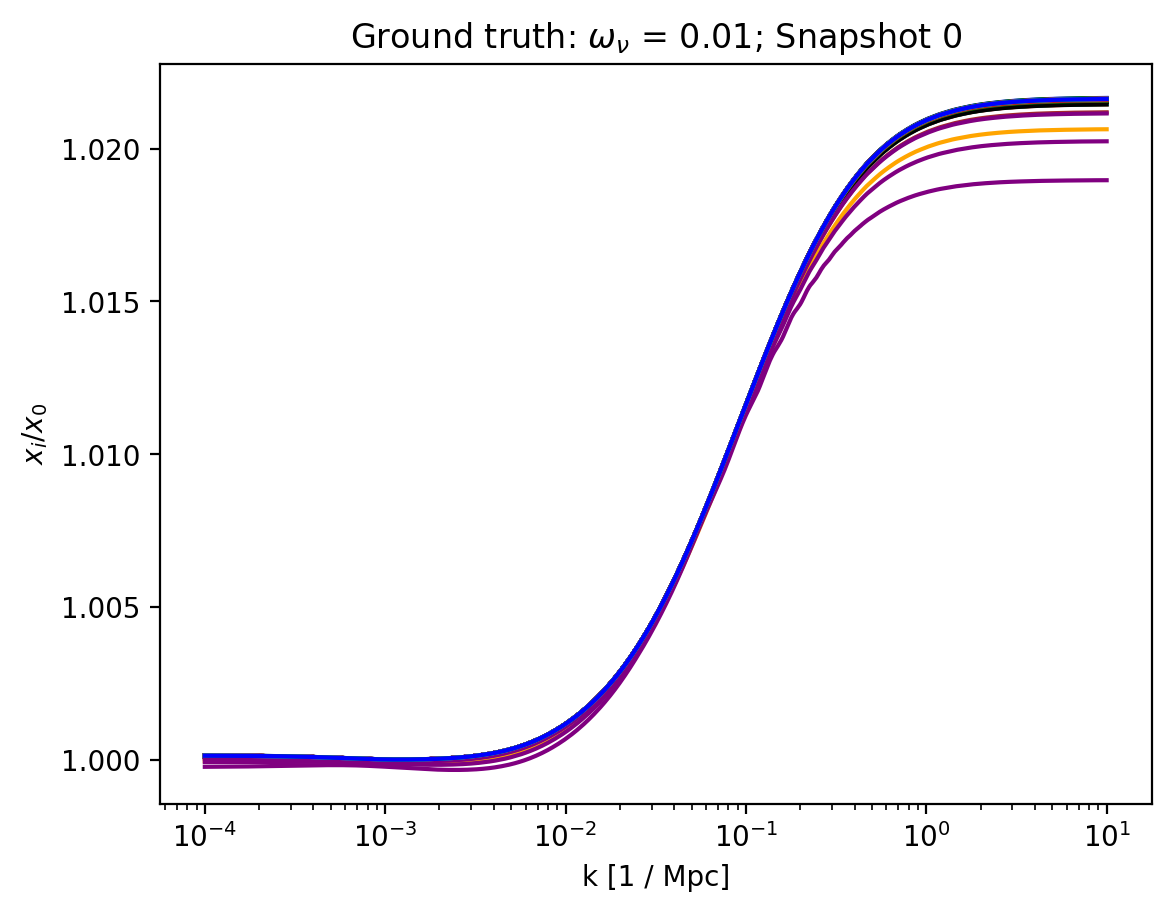

In [12]:
fig, axs = plt.subplots()
ks, rats = spectra.model_ratios_true(snap_index, spec_sims[onh2_str], axs,
    massive='x', skips=[], omnuh2_str=onh2_str, models=cosm,
    suppress_legend=True);

In [13]:
true_asymptotes = []

for model_i in range(len(rats)):
    tail_start_idx = len(rats[model_i]) - asymptote_sample_size
    tail = rats[model_i][tail_start_idx:len(rats[model_i])]
    true_asymptotes.append(np.average(tail))

true_asymptotes = np.array(true_asymptotes)

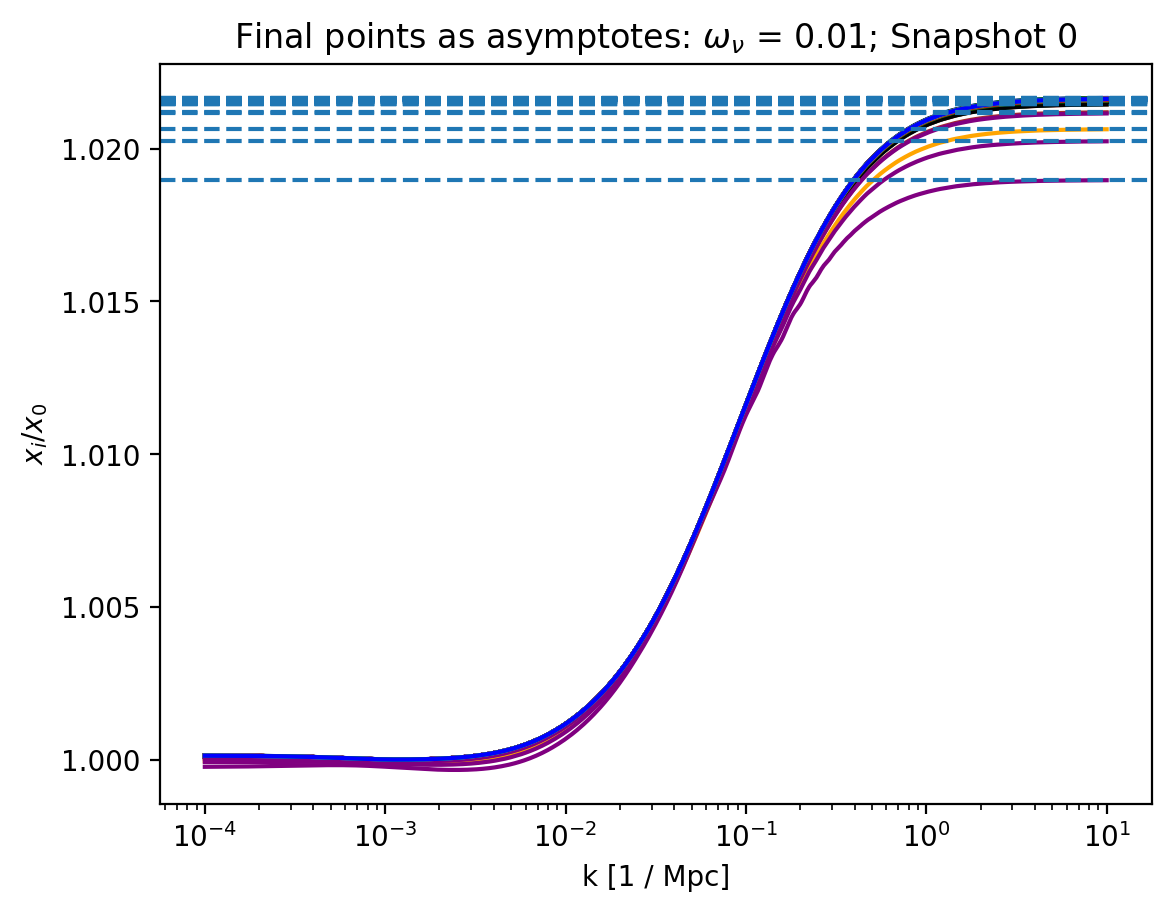

In [14]:
fig, axs = plt.subplots()
spectra.model_ratios_true(snap_index, spec_sims[onh2_str], axs,
    massive='x', skips=[], omnuh2_str=onh2_str,
    title="Final points as asymptotes", models=cosm, suppress_legend=True)
for asymptote in true_asymptotes:
    axs.axhline(asymptote, linestyle='--')

C:\Users\Lukas\Anaconda3\envs\ay160\lib\site-packages\numpy\polynomial\polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)


y-intercept for this fit is 1.021548194448433
slope for this fit is 0.0
Reduced chi squared value for this fit: 9.808171759231983e-08


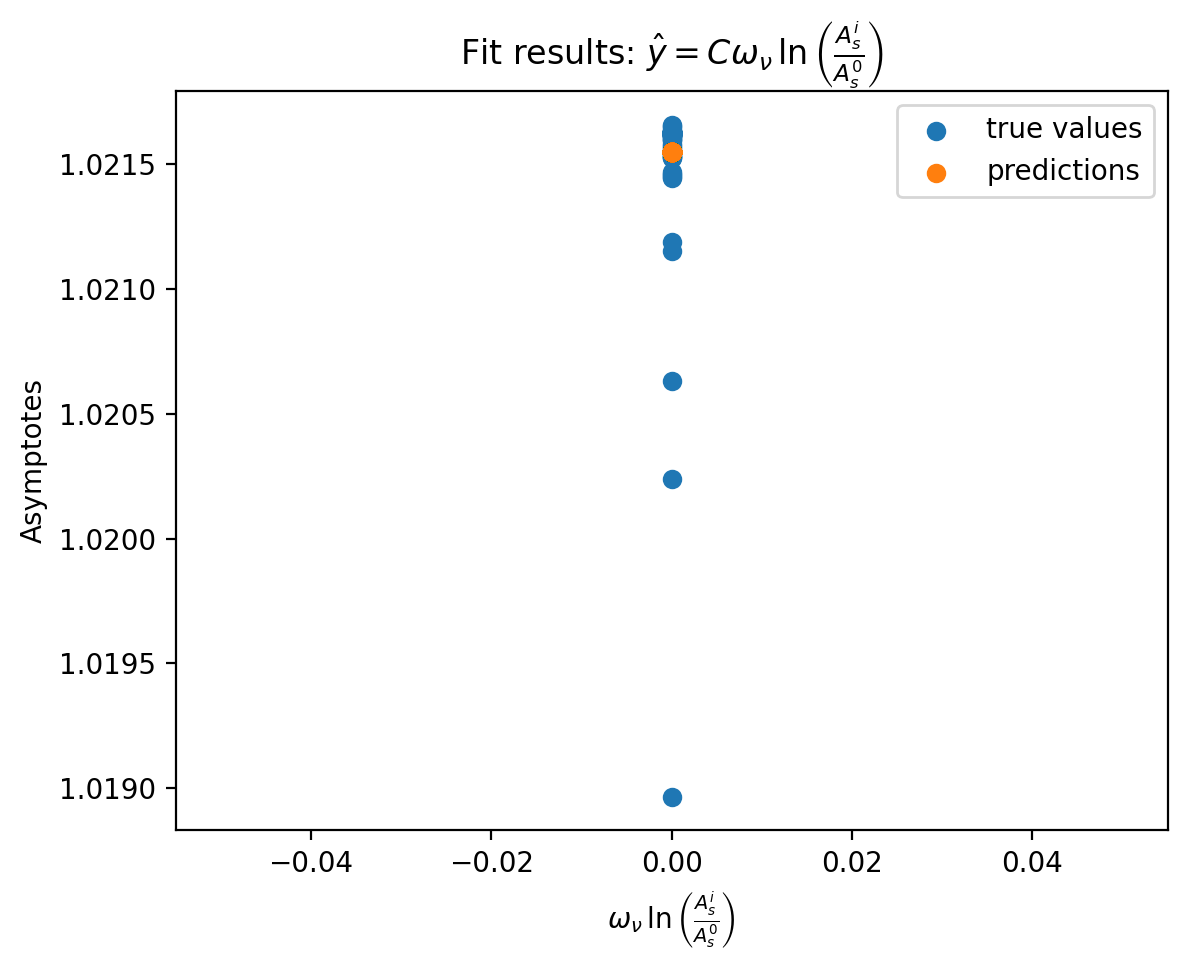

In [15]:
from numpy.polynomial.polynomial import polyfit
A_s = [cosm.loc[i]["A_s"] for i in range(1 + num_degenerate)]
x6 = onh2 * np.log(A_s[1:] / A_s[0])

model_desc_6 = r"\omega_\nu \, \ln \left( \frac{A_s^i}{A_s^0} \right)$"

plt.scatter(x6, true_asymptotes, label="true values")

b6, m6 = polyfit(x6, true_asymptotes, 1)

pred6 = m6 * x6 + b6
plt.scatter(x6, pred6, label="predictions")

print("y-intercept for this fit is", b6)
print("slope for this fit is", m6)

plt.ylabel("Asymptotes")
plt.xlabel("$" + model_desc_6)
plt.title(r"Fit results: $\hat{y} = C" + model_desc_6)
plt.legend()

chis6 = (true_asymptotes - pred6) ** 2 / pred6
red_chisq6 = sum(chis6) / len(x6)
print("Reduced chi squared value for this fit:", red_chisq6)

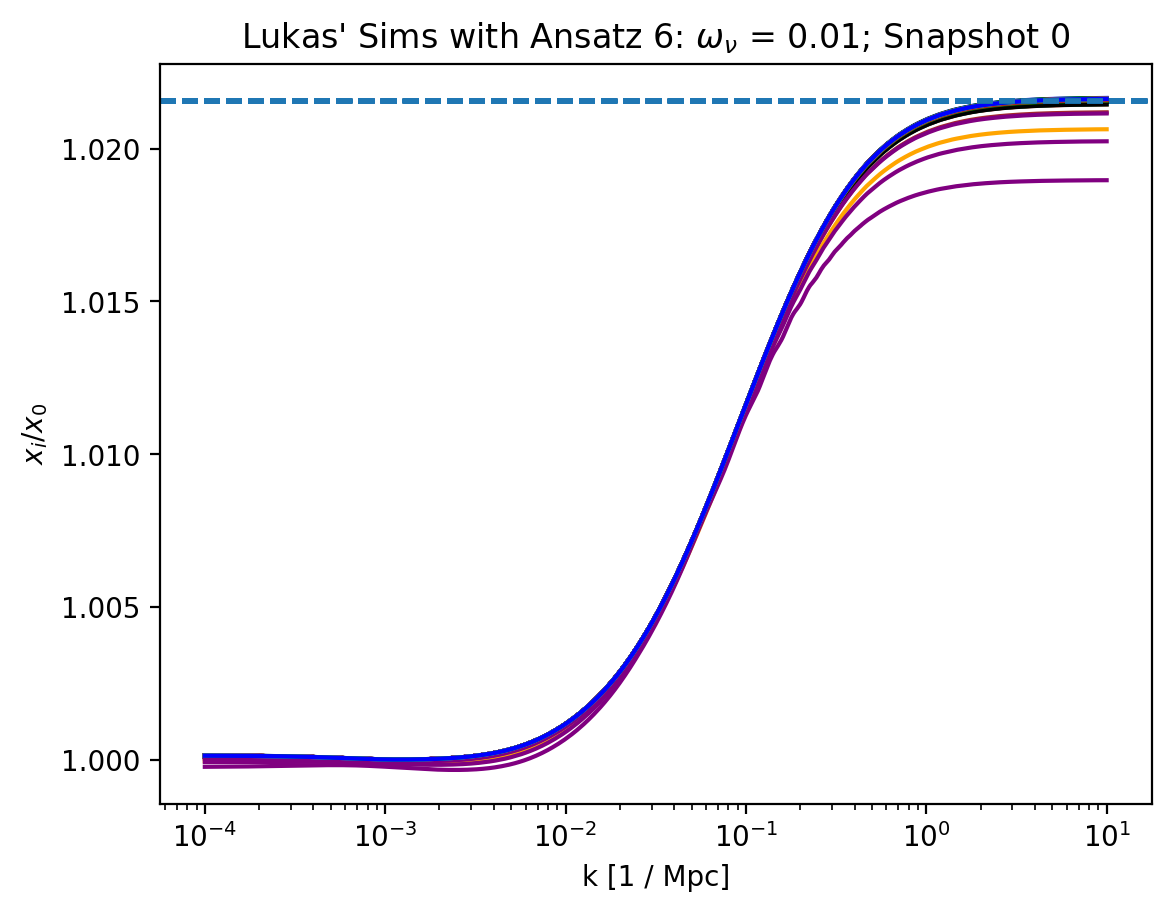

In [16]:
fig, axs = plt.subplots()
spectra.model_ratios_true(snap_index, spec_sims[onh2_str], axs,
    massive='x', omnuh2_str=onh2_str, models=cosm,
    title="Lukas' Sims with Ansatz 6", suppress_legend=True)

for i in range(len(true_asymptotes)):
    axs.axhline(m6 * x6[i] + b6, linestyle='--')

The estimates are pretty obviously misaligned in several cases, but that's okay,
because we're deliberately running this experiment at the worst omega_nu value
on the range: 0.01.

However, one thing I can't explain: why do the randomly-generated cosmologies
tend to cluster toward the higher side of this plot? The Aletheia set doesn't
have such a dramatic lopsidedness (see the notebook divergence_asymptotes), but
maybe the cosmologies were carefully selected to that end?

Unfortunately, chi-squared is not meaningful anymore because there is no
longer a common theme to the models (before, one could say that they were all
Aletheia cosmologies). All we can do is procure a maximum error term across
all randomly-generated cosmologies.

Text(0.5, 0, 'Percent error')

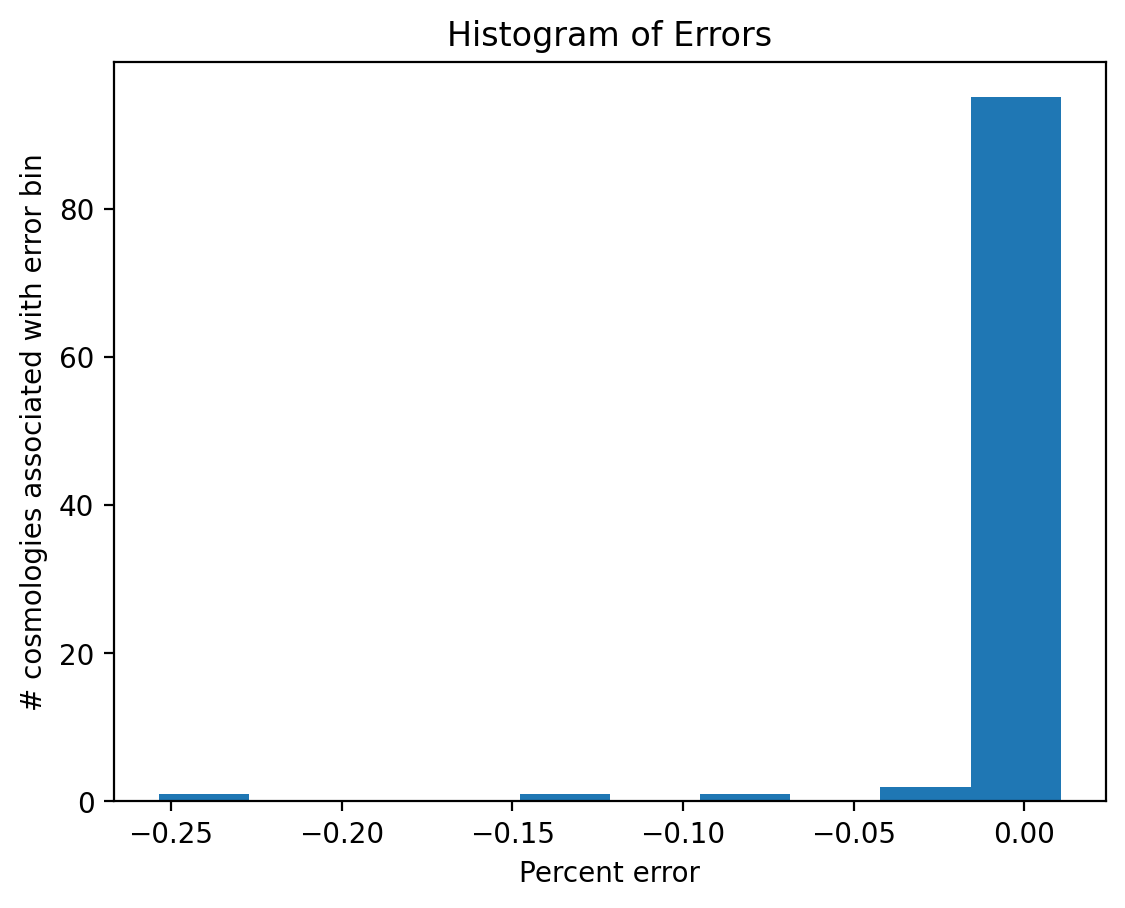

In [17]:
percent_error = (true_asymptotes - pred6) / true_asymptotes * 100
plt.hist(percent_error)
plt.title("Histogram of Errors")
plt.ylabel("# cosmologies associated with error bin")
plt.xlabel("Percent error")

In [18]:
print(max(percent_error))
print(min(percent_error))

0.010641961532019064
-0.2534815783834272


In [19]:
np.where([percent_error == min(percent_error)])

(array([0], dtype=int64), array([23], dtype=int64))

In [20]:
percent_error[60]

0.007969568709566974

In [21]:
cosm.iloc[60]

OmM      5.681765e-01
OmL      4.318235e-01
OmK      0.000000e+00
OmC      4.790041e-01
OmB      8.917238e-02
h        5.017006e-01
w0      -1.998652e+00
wa       3.214092e-01
omch2    1.205670e-01
ombh2    2.244500e-02
n_s      9.600000e-01
A_s      2.127238e-09
Name: 60, dtype: float64